What it does:
Recognizes dynamic finger movements, such as drawing shapes or waving, by analyzing the motion path of a fingertip over time.

✅ Example:
Circle motion → Label 0

Left to right swipe → Label 1

Zigzag or up-down motion → Label 2

📥 Input:
A flattened list of the past 16 positions of the index fingertip (x, y), converted to relative coordinates and normalized. So 16 points → 32 values.

⚙️ How it works:
When a pointing gesture is detected (hand_sign_id == 2), it tracks the fingertip (landmark #8).

The sequence is stored in a queue (point_history) and passed to the classifier.

You collect data in model/point_history_classifier/point_history.csv, then train the model.



In [67]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [68]:
import pickle
import pandas as pd

NUM_CLASSES = 30

DATA_ROOT = "../processed_wlasl_top30_holistic"

with open(f"{DATA_ROOT}/asl_landmarks.pkl", "rb") as f:
    all_landmarks = pickle.load(f)

df = pd.read_csv(f"{DATA_ROOT}/dataset_index.csv")

# Filter to only include videos that have landmarks
df = df[df["id"].astype(str).isin(all_landmarks.keys())].reset_index(drop=True)

print("Videos:", len(df))
print("Example landmark shape:", next(iter(all_landmarks.values())).shape)


Videos: 586
Example landmark shape: (60, 375)


In [69]:
all_labels = sorted(df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(all_labels)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(all_labels)
num_classes

30

In [70]:
import random
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

seed = 42
random.seed(seed)
np.random.seed(seed)

# Filter out classes with fewer than 2 samples (required for stratified split)
label_counts = df["label"].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df = df[df["label"].isin(valid_labels)].reset_index(drop=True)

print(f"After filtering classes with <2 samples: {len(df)} videos")
print(f"Number of classes: {len(valid_labels)}")

# Regenerate class mappings after filtering
all_labels = sorted(df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(all_labels)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(all_labels)
print(f"Final number of classes: {num_classes}")

# df contains: path, label, num_frames
labels = df["label"]

splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.20,      # 80% train, 20% test
    random_state=42
)

for train_idx, test_idx in splitter.split(df, labels):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

print("Train videos:", len(train_df))
print("Test videos:", len(test_df))


After filtering classes with <2 samples: 586 videos
Number of classes: 30
Final number of classes: 30
Train videos: 468
Test videos: 118


In [71]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
import random


class ASLDataset(Dataset):
    def __init__(self, df, landmarks_dict, class_to_idx, augment=False, aug_factor=3):
        """
        augment=False → only original samples
        augment=True  → add aug_factor synthetic samples per original
        """
        self.df = df.reset_index(drop=True)
        self.landmarks = landmarks_dict
        self.class_to_idx = class_to_idx
        self.augment = augment
        self.aug_factor = aug_factor

        self.samples = []  # list of (lm, label, is_augmented)

        # --------------------------
        # Build expanded dataset
        # --------------------------
        for _, row in self.df.iterrows():
            video_id = str(row["id"])
            label = class_to_idx[row["label"]]

            if video_id not in self.landmarks:
                continue

            lm = np.array(self.landmarks[video_id], dtype=np.float32)
            
            if augment:
                lm = self.apply_augmentation(lm.copy())

            # Add ORIGINAL sample
            self.samples.append((lm, label))

            # if augment:
            #     # # Add multiple augmented versions
            #     # for _ in range(aug_factor):
            #     aug_lm = self.temporal_warp(lm.copy())
            #     self.samples.append((aug_lm, label))
            #     aug_lm = self.add_noise(lm.copy())
            #     self.samples.append((aug_lm, label))
            #     aug_lm = self.jitter(lm.copy())
            #     self.samples.append((aug_lm, label))

        print(f"Dataset expanded: {len(self.df)} to {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lm, label = self.samples[idx]
        return torch.tensor(lm, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


    def apply_augmentation(self, lm):
        if random.random() < 0.50:
            lm = self.temporal_warp(lm)
        if random.random() < 0.80:
            lm = self.add_noise(lm)
        if random.random() < 0.80:
            lm = self.jitter(lm)
        return lm

    def temporal_warp(self, lm, warp_range=(0.9, 1.1)):
        num_frames = lm.shape[0]
        t = np.arange(num_frames)

        warp_factor = random.uniform(*warp_range)
        new_frames = int(num_frames * warp_factor)
        new_t = np.linspace(0, num_frames - 1, new_frames)

        warped = np.zeros((new_frames, lm.shape[1]), dtype=np.float32)
        for i in range(lm.shape[1]):
            f = interp1d(t, lm[:, i], fill_value="extrapolate")
            warped[:, i] = f(new_t)

        # resample back to original length
        final_t = np.linspace(0, new_frames - 1, num_frames)
        out = np.zeros_like(lm)
        for i in range(lm.shape[1]):
            f = interp1d(np.arange(new_frames), warped[:, i], fill_value="extrapolate")
            out[:, i] = f(final_t)
        return out

    def add_noise(self, lm, std=0.005):
        return lm + np.random.normal(0, std, lm.shape).astype(np.float32)

    def jitter(self, lm, max_jitter=0.01):
        return lm + np.random.uniform(-max_jitter, max_jitter, lm.shape).astype(np.float32)


In [72]:
from torch.utils.data import DataLoader

train_set = ASLDataset(train_df, all_landmarks, class_to_idx, augment=True)
test_set  = ASLDataset(test_df,  all_landmarks, class_to_idx, augment=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False)


Dataset expanded: 468 to 468 samples
Dataset expanded: 118 to 118 samples


In [73]:
class ASLTransformer(nn.Module):
    def __init__(self, input_dim=375, embed_dim=128, num_heads=8,
                 ff_dim=256, num_layers=4, num_classes=300, dropout=0.2):
        super().__init__()

        # Linear projection of each frame
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Learnable positional encoding (60,128)
        self.pos_embedding = nn.Parameter(torch.randn(1, 60, embed_dim))

        # Transformer encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        """
        x: (B, T, D) where T is number of frames (typically 60) and D is feature dimension (375 for holistic)
        """
        x = self.embedding(x)               # (B, T, 128)
        x = x + self.pos_embedding[:, :x.size(1), :]  # add positional info

        x = self.encoder(x)                 # (B, T, 128)

        # Mean pooling over time
        x = x.mean(dim=1)                   # (B, 128)

        return self.fc(x)


In [74]:
# Get input dimension from actual data
sample_landmark = next(iter(all_landmarks.values()))
input_dim = sample_landmark.shape[1]  # Should be 375 for holistic
print(f"Input dimension: {input_dim}")

model = ASLTransformer(
    input_dim=input_dim,
    embed_dim=128,
    num_heads=8,
    ff_dim=256,
    num_layers=4,
    num_classes=len(class_to_idx),
    dropout=0.2
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
criterion = nn.CrossEntropyLoss()

Input dimension: 375


/Volumes/Hien SSD/Codeee/deep-learning-final-project/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [75]:
best_acc = 0.0
best_epoch = 0
SAVE_PATH = f"best_model_{NUM_CLASSES}.pt"

history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(200):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # ----------------------------
    # TRAIN LOOP
    # ----------------------------
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_acc = correct / total * 100

    # ----------------------------
    # TEST EVAL
    # ----------------------------
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            t_loss = criterion(pred, y)
            test_loss += t_loss.item()

            _, predicted = torch.max(pred, 1)
            test_total += y.size(0)
            test_correct += (predicted == y).sum().item()

    test_acc = test_correct / test_total * 100

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    # ----------------------------
    # SAVE BEST MODEL
    # ----------------------------
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1

        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "test_acc": test_acc
        }, SAVE_PATH)

        print(f"\nNew best model saved! Epoch {epoch+1} — Test Acc: {test_acc:.2f}%\n")

    # ----------------------------
    # PRINT SUMMARY
    # ----------------------------
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss/len(train_loader):.4f} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Test Loss: {test_loss/len(test_loader):.4f} | "
            f"Test Acc: {test_acc:.2f}% | "
            f"Best: {best_acc:.2f}% (Epoch {best_epoch})"
        )


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]



New best model saved! Epoch 1 — Test Acc: 10.17%

Epoch 01 | Train Loss: 3.4616 | Train Acc: 3.85% | Test Loss: 3.2358 | Test Acc: 10.17% | Best: 10.17% (Epoch 1)


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]



New best model saved! Epoch 2 — Test Acc: 12.71%



100%|██████████| 15/15 [00:02<00:00,  5.88it/s]



New best model saved! Epoch 3 — Test Acc: 17.80%



100%|██████████| 15/15 [00:03<00:00,  4.81it/s]



New best model saved! Epoch 4 — Test Acc: 19.49%



100%|██████████| 15/15 [00:02<00:00,  5.07it/s]



New best model saved! Epoch 5 — Test Acc: 22.03%



100%|██████████| 15/15 [00:02<00:00,  5.73it/s]



New best model saved! Epoch 6 — Test Acc: 22.88%



100%|██████████| 15/15 [00:02<00:00,  5.08it/s]



New best model saved! Epoch 7 — Test Acc: 24.58%



100%|██████████| 15/15 [00:02<00:00,  5.46it/s]



New best model saved! Epoch 9 — Test Acc: 25.42%



100%|██████████| 15/15 [00:02<00:00,  5.22it/s]



New best model saved! Epoch 10 — Test Acc: 26.27%



100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


Epoch 11 | Train Loss: 2.5852 | Train Acc: 25.43% | Test Loss: 2.6707 | Test Acc: 26.27% | Best: 26.27% (Epoch 10)


100%|██████████| 15/15 [00:02<00:00,  5.75it/s]



New best model saved! Epoch 12 — Test Acc: 27.12%



100%|██████████| 15/15 [00:02<00:00,  5.89it/s]



New best model saved! Epoch 13 — Test Acc: 27.97%



100%|██████████| 15/15 [00:02<00:00,  6.09it/s]



New best model saved! Epoch 14 — Test Acc: 31.36%



100%|██████████| 15/15 [00:02<00:00,  6.33it/s]



New best model saved! Epoch 16 — Test Acc: 33.90%



100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch 21 | Train Loss: 2.2132 | Train Acc: 36.54% | Test Loss: 2.4421 | Test Acc: 30.51% | Best: 33.90% (Epoch 16)


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



New best model saved! Epoch 24 — Test Acc: 34.75%



100%|██████████| 15/15 [00:02<00:00,  5.17it/s]



New best model saved! Epoch 25 — Test Acc: 35.59%



100%|██████████| 15/15 [00:02<00:00,  6.44it/s]



New best model saved! Epoch 28 — Test Acc: 37.29%



100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


Epoch 31 | Train Loss: 1.9882 | Train Acc: 41.45% | Test Loss: 2.2638 | Test Acc: 34.75% | Best: 37.29% (Epoch 28)


100%|██████████| 15/15 [00:03<00:00,  4.93it/s]



New best model saved! Epoch 33 — Test Acc: 38.14%



100%|██████████| 15/15 [00:02<00:00,  6.37it/s]



New best model saved! Epoch 34 — Test Acc: 38.98%



100%|██████████| 15/15 [00:02<00:00,  6.96it/s]



New best model saved! Epoch 35 — Test Acc: 40.68%



100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


Epoch 41 | Train Loss: 1.7887 | Train Acc: 49.36% | Test Loss: 2.1103 | Test Acc: 38.98% | Best: 40.68% (Epoch 35)


100%|██████████| 15/15 [00:02<00:00,  5.90it/s]



New best model saved! Epoch 45 — Test Acc: 41.53%



100%|██████████| 15/15 [00:02<00:00,  6.32it/s]



New best model saved! Epoch 48 — Test Acc: 42.37%



100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


Epoch 51 | Train Loss: 1.6042 | Train Acc: 55.34% | Test Loss: 2.0217 | Test Acc: 38.14% | Best: 42.37% (Epoch 48)


100%|██████████| 15/15 [00:02<00:00,  6.22it/s]


Epoch 61 | Train Loss: 1.4582 | Train Acc: 60.26% | Test Loss: 1.9692 | Test Acc: 39.83% | Best: 42.37% (Epoch 48)


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]



New best model saved! Epoch 66 — Test Acc: 43.22%



100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


Epoch 71 | Train Loss: 1.3439 | Train Acc: 62.39% | Test Loss: 1.8809 | Test Acc: 41.53% | Best: 43.22% (Epoch 66)


100%|██████████| 15/15 [00:02<00:00,  7.20it/s]



New best model saved! Epoch 74 — Test Acc: 46.61%



100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


Epoch 81 | Train Loss: 1.3097 | Train Acc: 63.68% | Test Loss: 1.8734 | Test Acc: 44.07% | Best: 46.61% (Epoch 74)


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


Epoch 91 | Train Loss: 1.1949 | Train Acc: 63.89% | Test Loss: 1.8768 | Test Acc: 46.61% | Best: 46.61% (Epoch 74)


100%|██████████| 15/15 [00:02<00:00,  7.27it/s]



New best model saved! Epoch 93 — Test Acc: 47.46%



100%|██████████| 15/15 [00:02<00:00,  7.35it/s]



New best model saved! Epoch 96 — Test Acc: 49.15%



100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


Epoch 101 | Train Loss: 1.1073 | Train Acc: 67.09% | Test Loss: 1.7707 | Test Acc: 44.92% | Best: 49.15% (Epoch 96)


100%|██████████| 15/15 [00:02<00:00,  7.43it/s]



New best model saved! Epoch 105 — Test Acc: 50.00%



100%|██████████| 15/15 [00:02<00:00,  7.25it/s]



New best model saved! Epoch 107 — Test Acc: 50.85%



100%|██████████| 15/15 [00:02<00:00,  7.39it/s]


Epoch 111 | Train Loss: 1.0399 | Train Acc: 71.79% | Test Loss: 1.7086 | Test Acc: 47.46% | Best: 50.85% (Epoch 107)


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]



New best model saved! Epoch 116 — Test Acc: 52.54%



100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Epoch 121 | Train Loss: 1.0215 | Train Acc: 70.30% | Test Loss: 1.6602 | Test Acc: 50.85% | Best: 52.54% (Epoch 116)


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]



New best model saved! Epoch 131 — Test Acc: 54.24%

Epoch 131 | Train Loss: 0.8999 | Train Acc: 73.50% | Test Loss: 1.6759 | Test Acc: 54.24% | Best: 54.24% (Epoch 131)


100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch 141 | Train Loss: 0.9555 | Train Acc: 71.79% | Test Loss: 2.0337 | Test Acc: 47.46% | Best: 54.24% (Epoch 131)


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]



New best model saved! Epoch 147 — Test Acc: 55.08%



100%|██████████| 15/15 [00:02<00:00,  6.63it/s]


Epoch 151 | Train Loss: 0.7951 | Train Acc: 76.50% | Test Loss: 1.6388 | Test Acc: 54.24% | Best: 55.08% (Epoch 147)


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


Epoch 161 | Train Loss: 0.7957 | Train Acc: 76.92% | Test Loss: 1.6655 | Test Acc: 50.85% | Best: 55.08% (Epoch 147)


100%|██████████| 15/15 [00:02<00:00,  5.69it/s]



New best model saved! Epoch 170 — Test Acc: 55.93%



100%|██████████| 15/15 [00:02<00:00,  5.59it/s]



New best model saved! Epoch 171 — Test Acc: 57.63%

Epoch 171 | Train Loss: 0.6532 | Train Acc: 81.62% | Test Loss: 1.5470 | Test Acc: 57.63% | Best: 57.63% (Epoch 171)


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]



New best model saved! Epoch 178 — Test Acc: 59.32%



100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch 181 | Train Loss: 0.7427 | Train Acc: 77.14% | Test Loss: 1.7328 | Test Acc: 50.85% | Best: 59.32% (Epoch 178)


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


Epoch 191 | Train Loss: 0.5675 | Train Acc: 83.55% | Test Loss: 1.6138 | Test Acc: 54.24% | Best: 59.32% (Epoch 178)


100%|██████████| 15/15 [00:02<00:00,  7.26it/s]


In [76]:
checkpoint = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.to(device)

ASLTransformer(
  (embedding): Linear(in_features=375, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [77]:
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            _, predicted = pred.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total

print("Final Test Accuracy (Best Model):", evaluate(test_loader) * 100, "%")

Final Test Accuracy (Best Model): 59.32203389830508 %


In [78]:
import torch.nn.functional as F
def predict_video(model, landmarks, idx_to_class):
    """
    landmarks: (T, D) numpy or tensor where T is number of frames (typically 60) and D is feature dimension (375 for holistic)
    idx_to_class: dictionary mapping class index to class name (from training)
    """
    model.eval()
    if isinstance(landmarks, np.ndarray):
        landmarks = torch.tensor(landmarks, dtype=torch.float32)

    with torch.no_grad():
        x = landmarks.unsqueeze(0).to(next(model.parameters()).device)  # (1, T, D)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)
        
        pred_idx_val = pred_idx.item()
        
        # Bounds checking
        if pred_idx_val not in idx_to_class:
            # Fallback: use the index if it's within a reasonable range
            max_idx = max(idx_to_class.keys()) if idx_to_class else 0
            if pred_idx_val > max_idx:
                pred_idx_val = max_idx
            elif pred_idx_val < 0:
                pred_idx_val = 0
            # If still not found, use first class
            if pred_idx_val not in idx_to_class:
                pred_idx_val = min(idx_to_class.keys()) if idx_to_class else 0

    pred_word = idx_to_class.get(pred_idx_val, f"Unknown_{pred_idx_val}")
    confidence = conf.item()

    return pred_word, confidence


In [79]:
def print_predictions(model, df, landmarks_dict, idx_to_class, num_samples=10):
    """
    Randomly prints `num_samples` predictions from df.
    
    Args:
        model: Trained model
        df: DataFrame with test data
        landmarks_dict: Dictionary mapping video_id to landmarks
        idx_to_class: Dictionary mapping class index to class name (from training)
        num_samples: Number of samples to predict
    """
    sample_df = df.sample(num_samples).reset_index(drop=True)

    for i in range(len(sample_df)):
        video_id = str(sample_df.iloc[i]["id"])  # Convert to string to match landmarks dict keys
        path = sample_df.iloc[i]["path"]
        true_label = sample_df.iloc[i]["label"]
        
        if video_id not in landmarks_dict:
            print(f"{i+1}. {path}")
            print(f"   True:      {true_label}")
            print(f"   Predicted: ERROR - Video ID {video_id} not found in landmarks")
            print()
            continue
            
        lm = landmarks_dict[video_id]
        pred, conf = predict_video(model, lm, idx_to_class)

        print(f"{i+1}. {path}")
        print(f"   True:      {true_label}")
        print(f"   Predicted: {pred}  (conf: {conf:.2f})")
        print()


In [80]:
print_predictions(model, test_df, all_landmarks, idx_to_class, num_samples=10)

1. wlasl-complete/videos/70361.mp4
   True:      finish
   Predicted: finish  (conf: 0.98)

2. wlasl-complete/videos/14855.mp4
   True:      deaf
   Predicted: drink  (conf: 0.62)

3. wlasl-complete/videos/17718.mp4
   True:      drink
   Predicted: chair  (conf: 0.35)

4. wlasl-complete/videos/57942.mp4
   True:      thin
   Predicted: thin  (conf: 0.56)

5. wlasl-complete/videos/64219.mp4
   True:      year
   Predicted: year  (conf: 0.70)

6. wlasl-complete/videos/36931.mp4
   True:      mother
   Predicted: mother  (conf: 0.72)

7. wlasl-complete/videos/57637.mp4
   True:      thanksgiving
   Predicted: thanksgiving  (conf: 0.46)

8. wlasl-complete/videos/21874.mp4
   True:      fine
   Predicted: fine  (conf: 0.59)

9. wlasl-complete/videos/70299.mp4
   True:      like
   Predicted: like  (conf: 0.38)

10. wlasl-complete/videos/13646.mp4
   True:      cousin
   Predicted: cousin  (conf: 0.70)



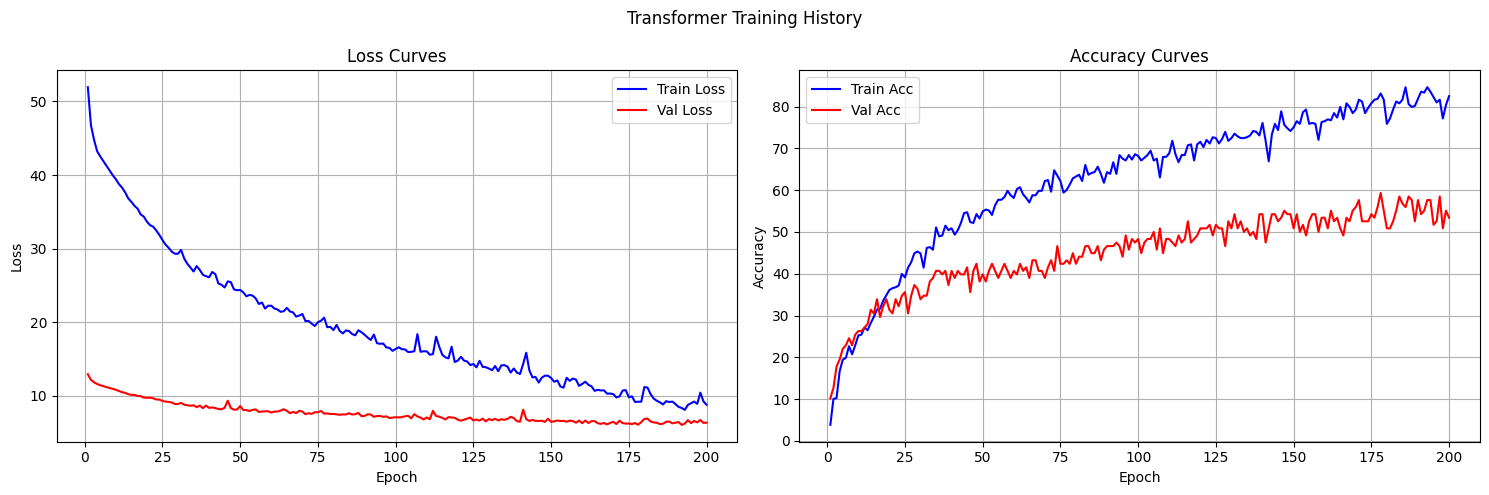

In [85]:

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Plot loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['test_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
ax2.plot(epochs, history['test_acc'], 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.suptitle("Transformer Training History")
plt.tight_layout()
plt.show()
